In [2]:
import numpy as np
import pandas as pd
import jittor as jt
import os
from os.path import join, getsize

from jittor.dataset import Dataset
from PIL import Image
from dataset import Tiny_vid
import matplotlib.pyplot as plt



[i 0418 11:27:59.476793 92 compiler.py:951] Jittor(1.3.2.5) src: /opt/miniconda/envs/dhy/lib/python3.9/site-packages/jittor
[i 0418 11:27:59.515964 92 compiler.py:952] g++ at /usr/bin/g++(9.3.0)
[i 0418 11:27:59.517083 92 compiler.py:953] cache_path: /home/dhy/.cache/jittor/jt1.3.2/g++9.3.0/py3.9.7/Linux-3.10.0-1xeb/IntelRXeonRGolx19/default
[i 0418 11:27:59.584226 92 install_cuda.py:51] cuda_driver_version: [11, 4]
[i 0418 11:27:59.598008 92 __init__.py:411] Found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/bin/nvcc(11.2.152) at /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/bin/nvcc.
[i 0418 11:27:59.810154 92 __init__.py:411] Found gdb(9.2) at /usr/bin/gdb.
[i 0418 11:27:59.828171 92 __init__.py:411] Found addr2line(2.34) at /usr/bin/addr2line.
[i 0418 11:28:00.045446 92 compiler.py:1006] cuda key:cu11.2.152_sm_86
[i 0418 11:28:00.323524 92 __init__.py:227] Total mem: 251.43GB, using 16 procs for compiling.


[i 0418 11:28:33.501430 92 log.cc:351] Load log_sync: 1
[i 0418 11:28:33.502654 92 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 0418 11:28:33.690704 92 init.cc:62] Found cuda archs: [86,]


Compiling jittor_core(148/148) used: 32.612s eta: 0.000s


[i 0418 11:28:33.741614 92 compile_extern.py:516] mpicc not found, distribution disabled.


Compiling gen_ops_cutt_test_cutt_transpose(4/4) used: 2.136s eta: 0.000s
Compiling gen_ops_mkl_conv_backward_w_mkl_conv_backward_x_mk___hashc4699b(7/7) used: 3.573s eta: 0.000s
Compiling libcuda_extern(3/3) used: 2.618s eta: 0.000s
Compiling gen_ops_cub_arg_reduce_cub_argsort_cub_cumsum_cub____hash3ccf67(6/6) used: 3.508s eta: 0.000s


[i 0418 11:28:46.308172 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/include/cublas.h
[i 0418 11:28:46.329282 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcublas.so
[i 0418 11:28:46.331154 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcublasLt.so.11


Compiling gen_ops_cublas_batched_matmul_cublas_matmul_cublas___hashde0e83(7/7) used: 2.309s eta: 0.000s


[i 0418 11:28:49.459783 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/include/cudnn.h
[i 0418 11:28:49.502178 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcudnn.so.8
[i 0418 11:28:49.503773 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcudnn_ops_infer.so.8
[i 0418 11:28:49.511599 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcudnn_ops_train.so.8
[i 0418 11:28:49.513175 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcudnn_cnn_infer.so.8
[i 0418 11:28:49.572354 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcudnn_cnn_train.so.8


Compiling gen_ops_cudnn_conv3d_backward_w_cudnn_conv3d_backw___hash78c3ee(16/16) used: 6.225s eta: 0.000s


[i 0418 11:28:57.145197 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/include/curand.h
[i 0418 11:28:57.231869 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcurand.so
[i 0418 11:28:59.307448 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/include/cufft.h
[i 0418 11:28:59.381742 92 compile_extern.py:30] found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/lib64/libcufft.so


In [3]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

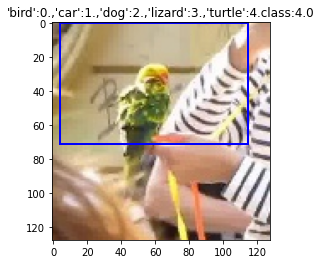

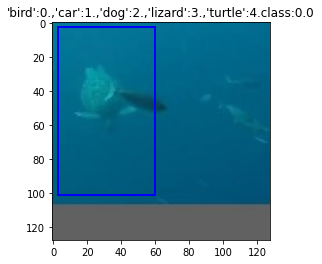

KeyboardInterrupt: Interrupted by user

In [18]:
dataset = Tiny_vid().set_attrs(batch_size=1, shuffle=True)
class_dict = {'bird':0.,'car':1.,'dog':2.,'lizard':3.,'turtle':4.}
from IPython import display
for x, y in dataset:
    plt.figure()
    ax = plt.imshow(x.squeeze(0))
    test_bbox = np.floor(y[1]*128)
    test_bbox = test_bbox.squeeze(0).tolist()
    ax.axes.add_patch(bbox_to_rect(test_bbox, 'blue'))
    plt.title(f"'bird':0.,'car':1.,'dog':2.,'lizard':3.,'turtle':4.class:{y[0]}")    
    plt.show()
    a = input("aa:")
    if a == '1':
        display.clear_output(wait=True)
        continue
    if a == '2':
        break

In [ ]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    import pdb;pdb.set_trace()

    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clip(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [ ]:
ba = jt.randn((16,4))
bb = jt.randn((16,4))

box_iou(ba,bb)

> /tmp/ipykernel_107969/2156307528.py(16)box_iou()
     14     # inter_upperlefts,inter_lowerrights,inters的形状:
     15     # (boxes1的数量,boxes2的数量,2)
---> 16     inter_upperlefts = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
     17     inter_lowerrights = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
     18     inters = (inter_lowerrights - inter_upperlefts).clip(min=0)

*** NameError: name 'area1' is not defined
jt.Var([-0.47100192 -0.28964293  4.51104    -0.0481187  -2.804784   -1.1222007
 -0.07610058  0.04101812 -0.20732325 -0.01257543  2.1593902   0.42317528
 -0.44248468  0.8959263  -1.6156423  -4.314989  ], dtype=float32)
jt.Var([-0.47100192 -0.28964293  4.51104    -0.0481187  -2.804784   -1.1222007
 -0.07610058  0.04101812 -0.20732325 -0.01257543  2.1593902   0.42317528
 -0.44248468  0.8959263  -1.6156423  -4.314989  ], dtype=float32)
jt.Var([-0.47100192 -0.28964293  4.51104    -0.0481187  -2.804784   -1.1222007
 -0.07610058  0.04101812 -0.20732325 -0.01257543  2.1593902   0

BdbQuit: 